<a href="https://colab.research.google.com/github/jsb616/AIStudy25/blob/master/09_02_LSTM_GRU(%EC%88%9C%ED%99%98%EC%8B%A0%EA%B2%BD%EB%A7%9D).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

LSTM과 GRU 셀 : 순환 신경망에서 빼놓을 수 없는 핵심 기술

<br>

전에 배웠던 SimpleRNN보다 훨씬 복잡하지만 성능이 뛰어나기 때문에 순환 신경망에 많이 채택됨

일반적으로 기본 순환층은 긴 시퀀스를 학습하기 어렵다.

시퀀스가 길수록 순환되는 은닉 상태에 담긴 정보가 점차 희석됨

멀리 떨어져 있는 단어 정보를 인식하는데 어려울 수 있음. 그래서 LSTM과 GRU를 사용함

<br>

LSTM(Long Short-Term Memory)는 말 그대로 "단기 기억을 오래 기억하기 위해서 고안됨"

기본 개념은 동일함

입력과 가중치를 곱하고 절편을 더해 활성화 함수를 통과시키는 구조를 여러 개 가짐

이런 계산 결과는 다음 타임스텝에 재사용됨

<br>

1. 은닉 상태 만듦 : 입력과 이전 타임스텝의 은닉 상태를 가중치에 곱한 후 활성화 함수를 통과시켜 다음 은닉 상태를 만듦

 이때 기본 순환층과는 달리 시그모이드 활성화 함수를 사용함

 또 tanh 활성화 함수를 통과한 어떤 값과 곱해져서 은닉 상태를 만듦

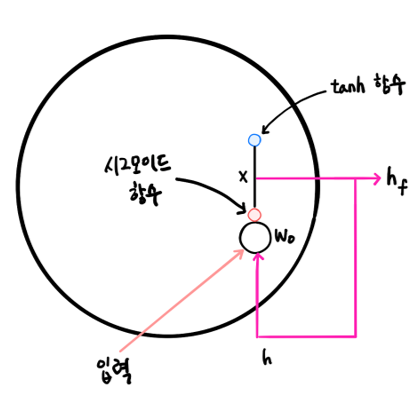

위 그림은 가중치 W_x와 W_h를 통틀어 W_o라고 표시함

파란색 원은 tanh 함수, 주황색 원은 시그모이드 함수임

x는 곱셈을 나타내고 있음 -> 기본 순환층과 크게 다르지 않음

<br>

tanh 함수를 통과하는 값은???

LSTM에는 순환되는 상태가 2개이다. (은닉상태, 셀 상태)

은닉상태와 달리 셀 상태는 다음 층으로 전달되지 않고, LSTM 셀에서 순환만 되는 값이다.

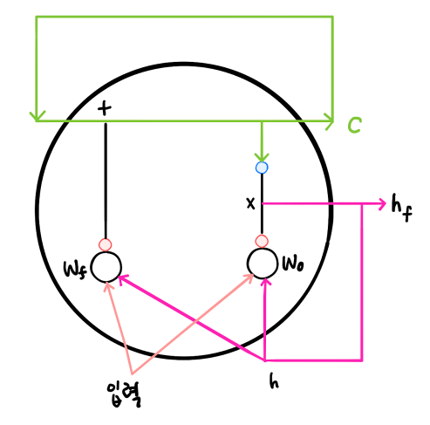

위 그림의 녹색은 순환되는 셀의 상태임

셀 상태를 은닉 상태 h와 구분하여 c로 표시함

<br>

**셀 상태를 계산하는 과정**

먼저 입력과 은닉 상태를 또 가중치 W_f에 곱한 다음 시그모이드 함수를 통과함

그 다음 이전 타임스텝의 셀 상태와 곱항여 새로운 셀 상태를 만듦

이 셀 상태가 오른쪽에서 tanh 함수를 통과하여 새로운 은닉 상태를 만드는 데 기여함

LSTM은 마치 작은 셀을 여러 개 포함하고 있는 큰 셀 같다.

중요한 것은 입력과 은닉 상태에서 곱해지는 가중치 W_o와 W_f가 다름
<br>
 -> 이 두 작은 셀은 각기 다른 기능을 위해 훈련됨

<br>

여기에 2개의 작은 셀이 더 추가되어 셀의 상태를 만드는 데 기여함

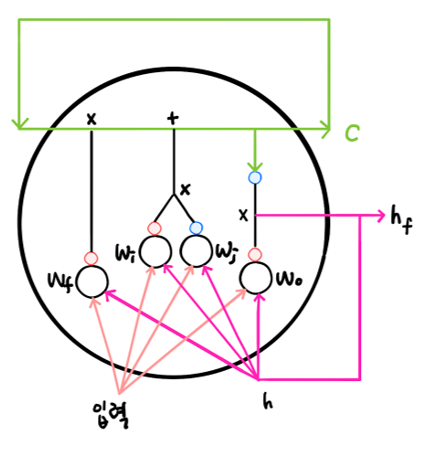

위 그림을 보면 이전과 마찬가지로 입력과 은닉 상태를 각기 다른 가중치에 곱한 다음

하나는 시그모이드 함수를 통과, 다른 하나는 tanh 함수를 통과시킨다.

그 다음 두 결과를 곱한 후 이전 셀의 상태와 더함 (최종 상태의 셀임)

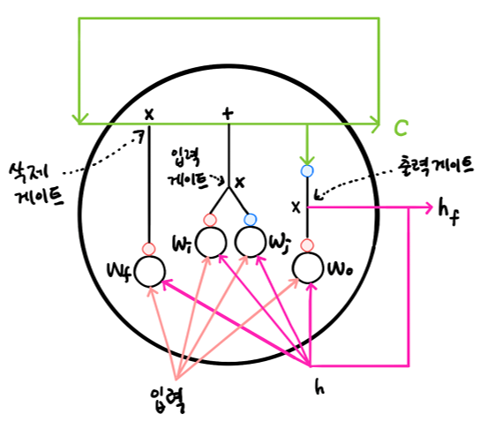

세 군데 곱셈을 삭제 게이트, 입력 게이트, 출력 게이트라고 부름

삭제 게이트는 셀의 상태에 있는 정보를 제거하는 역할

입력 게이트는 새로운 정보를 셀 상태에 추가

출력 게이트를 통해 이 셀 상태가 다음 은닉 상태로 출력

위의 처리는 케라스의 LSTM 클래스가 알아서 돌림

In [1]:
# LSTM 신경망 훈련하기
# 실행마다 동일한 결과를 얻기 위해 케라스의 랜덤 시드를 사용하고
# 텐서플로 연산을 결정적으로 만듭니다.
import tensorflow as tf

tf.keras.utils.set_random_seed(42)

from tensorflow.keras.datasets import imdb
from sklearn.model_selection import train_test_split

(train_input, train_target), (test_input, test_target) = imdb.load_data(num_words=500)  # 어휘사전을 500로 증가시켜 실습

train_input, val_input, train_target, val_target = train_test_split(train_input, train_target, test_size=0.2, random_state=42)

print(train_input.shape, val_input.shape, test_input.shape)

17464789/17464789 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
(20000,) (5000,) (25000,)


In [2]:
# 케라스의 pad_sequences() 함수로 각 샘플의 길이를 100에 맞추고 부족할 때 패딩을 추가함
from tensorflow.keras.preprocessing.sequence import pad_sequences

train_seq = pad_sequences(train_input, maxlen=100)  # truncating='pre' 생략가능
val_seq = pad_sequences(val_input, maxlen=100)

print(train_seq[5])     # 여섯번째 샘플을 확인해보면 앞쪽에 0으로 채워짐

[  0   0   0   0   1   2 195  19  49   2   2 190   4   2 352   2 183  10
  10  13  82  79   4   2  36  71 269   8   2  25  19  49   7   4   2   2
   2   2   2  10  10  48  25  40   2  11   2   2  40   2   2   5   4   2
   2  95  14 238  56 129   2  10  10  21   2  94 364 352   2   2  11 190
  24 484   2   7  94 205 405  10  10  87   2  34  49   2   7   2   2   2
   2   2 290   2  46  48  64  18   4   2]


In [3]:
# LSTM 셀을 사용한 순환층을 만들어보자! (예전에 썼던 SimpleRNN 클래스를 LSTM으로 변경만 하면 됨)
from tensorflow import keras

model = keras.Sequential()

model.add(keras.layers.Embedding(500, 16, input_shape=(100,)))  # 벡터 이용한 토큰 처리
#                                num_words=500 어휘사전 크기
#                                      임베딩 벡터 크기 16
#                                          maxlen=100
model.add(keras.layers.LSTM(8))     # 뉴런 개수 8
model.add(keras.layers.Dense(1, activation='sigmoid'))      # 활성화 함수 시그모이드 (2진분류)

model.summary()
# SimpleRNN 클래스의 모델 파라미터 개수는 200개였다.
# LSTM 셀에는 작은 셀이 4개 있으므로 정확히 800임 (200 * 4 = 800)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 100, 16)             │           8,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 8)                   │             800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │               9 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,809 (34.41 KB)

 Trainable params: 8,809 (34.41 KB)

 Non-trainable params: 0 (0.00 B)

In [4]:
# 컴파일하고 훈련 시작
rmsprop = keras.optimizers.RMSprop(learning_rate=1e-4)
model.compile(optimizer=rmsprop, loss='binary_crossentropy', metrics=['accuracy'])

checkpoint_cb = keras.callbacks.ModelCheckpoint('best-lstm-model.keras', save_best_only=True)

early_stopping_cb = keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)

# 배치 크기는 64개, 에포크 횟수는 100으로 지정
history = model.fit(train_seq, train_target, epochs=100, batch_size=64, # batch_size=64, 몇개의 샘플로 가중치를 갱신할 것인지 설정합니다
                    validation_data=(val_seq, val_target),
                    callbacks=[checkpoint_cb, early_stopping_cb])   # 체크포인트, 조기종료 동일

Epoch 1/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 20s 51ms/step - accuracy: 0.5110 - loss: 0.6929 - val_accuracy: 0.5864 - val_loss: 0.6911
Epoch 2/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 20s 48ms/step - accuracy: 0.5784 - loss: 0.6907 - val_accuracy: 0.6258 - val_loss: 0.6874
Epoch 3/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 20s 46ms/step - accuracy: 0.6217 - loss: 0.6858 - val_accuracy: 0.6562 - val_loss: 0.6765
Epoch 4/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 14s 46ms/step - accuracy: 0.6681 - loss: 0.6682 - val_accuracy: 0.7096 - val_loss: 0.6177
Epoch 5/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 20s 46ms/step - accuracy: 0.7180 - loss: 0.6006 - val_accuracy: 0.7248 - val_loss: 0.5760
Epoch 6/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 23s 53ms/step - accuracy: 0.7282 - loss: 0.5690 - val_accuracy: 0.7404 - val_loss: 0.5555
Epoch 7/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 19s 49ms/step - accuracy: 0.7481 - loss: 0.5465 - val_accuracy: 0.7450 - val_loss: 0.5383
Epoch 8/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 20s 48ms/step - accuracy: 0.7600 - loss: 0

16분 정도 걸림. 52회 에포크에 81.67% 정확도로 나옴

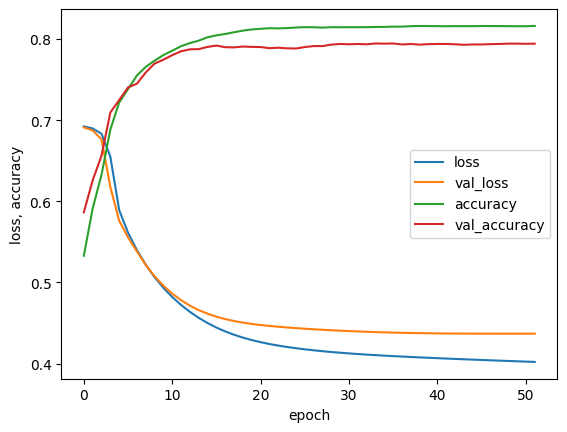

In [5]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('epoch')
plt.ylabel('loss, accuracy')
plt.legend(['loss', 'val_loss', 'accuracy', 'val_accuracy'])
plt.show()

결과를 보면 기본 순환층보다 LSTM이 과대적합을 억제하면서 훈련을 잘 수행하는 것처럼 보임

하지만 경우에 따라서 과대적합을 더 강하게 제어할 필요가 있다. (드롭 아웃)

<br>

완전 연결 신경망과 합성곱 신경망에서는 Dropout 클래스를 사용해서 드롭아웃을 적용하였다.

이를 통해 모델이 훈련 세트에 너무 과대적합되는 것을 막았음

<br>

순환층은 자체적으로 드롭아웃 기능을 제공한다.
<br>
 -> 드롭아웃 : 은닉층에 있는 뉴런의 출력을 랜덤하게 꺼서 과대적합을 막음

<br>

SimpleRNN과 LSTM 클래스 모두 dropout 매개변수와 recurrent_dropout 매개변수를 가지고 있음

dropout은 셀의 입력에 드롭아웃을 적용, recurrent_dropout은 순환 은닉 상태에 드롭아웃을 적용함

recurrent_dropout을 사용하면 GRU를 사용하여 모델을 훈련하지 못 함(모델의 훈련 속도가 크게 느려짐)

그래서 이번에는 dropout만 적용해보겠다.

In [6]:
model2 = keras.Sequential()

model2.add(keras.layers.Embedding(500, 16, input_shape=(100,)))
model2.add(keras.layers.LSTM(8, dropout=0.3))   # 드롭아웃 매개값 0.3으로 지정 (30% 입력의 드롭아웃)
model2.add(keras.layers.Dense(1, activation='sigmoid'))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [7]:
rmsprop = keras.optimizers.RMSprop(learning_rate=1e-4)
model2.compile(optimizer=rmsprop, loss='binary_crossentropy', metrics=['accuracy'])

checkpoint_cb = keras.callbacks.ModelCheckpoint('best-dropout-model.keras', save_best_only=True)

early_stopping_cb = keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)

history = model2.fit(train_seq, train_target, epochs=100, batch_size=64,
                     validation_data=(val_seq, val_target),
                     callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 18s 49ms/step - accuracy: 0.5145 - loss: 0.6930 - val_accuracy: 0.5716 - val_loss: 0.6922
Epoch 2/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 21s 52ms/step - accuracy: 0.5619 - loss: 0.6920 - val_accuracy: 0.6068 - val_loss: 0.6908
Epoch 3/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 20s 49ms/step - accuracy: 0.6025 - loss: 0.6902 - val_accuracy: 0.6288 - val_loss: 0.6879
Epoch 4/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 21s 50ms/step - accuracy: 0.6257 - loss: 0.6865 - val_accuracy: 0.6490 - val_loss: 0.6809
Epoch 5/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 21s 52ms/step - accuracy: 0.6458 - loss: 0.6773 - val_accuracy: 0.6560 - val_loss: 0.6494
Epoch 6/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 17s 53ms/step - accuracy: 0.6848 - loss: 0.6394 - val_accuracy: 0.7270 - val_loss: 0.5991
Epoch 7/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 15s 47ms/step - accuracy: 0.7198 - loss: 0.5997 - val_accuracy: 0.7404 - val_loss: 0.5803
Epoch 8/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 21s 50ms/step - accuracy: 0.7326 - loss: 0

드롭아웃 전에는 52회 에포크에 81.67% 정확도로 나옴 16분 걸림

드롭이웃 이후에는 43회 에포크에 81.67% 정확도 이고 13분 걸림

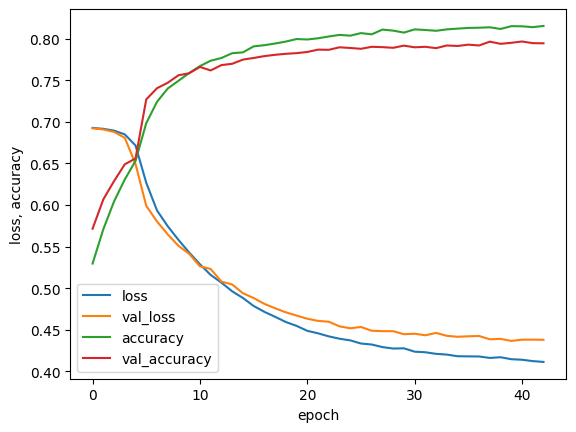

In [9]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('epoch')
plt.ylabel('loss, accuracy')
plt.legend(['loss', 'val_loss','accuracy', 'val_accuracy'])
plt.show() # 훈련손실과 검증 손실 차이가 좁혀진 것을 확인 할 수 있음

# 드롭아웃 전 : Epoch 52/100 accuracy: 0.8167 - loss: 0.4013 - val_accuracy: 0.7944 - val_loss: 0.4368
# 0.4368 - 0.4013 = 0.0355

# 드롭아웃 후 : Epoch 43/100 accuracy: 0.8167 - loss: 0.4109 - val_accuracy: 0.7944 - val_loss: 0.4381
# 0.4381 - 0.4109 = 0.0272

드롭아웃을 해서 그래프가 튀게 나옴

---

전에도 Conv2D를 2개로 쌓아 훈련을 진행하였다.

이번에도 LSTM을 2개 만들어 2개의 층으로 연결해보자.

<br>

순환층을 연결할 때는 한 가지 주의할 점이 있는데

순환층의 은닉 상태는 샘플의 마지막 타임스텝에 대한 은닉 상태만 다음 층으로 전달됨!!

return_sequences=True

<br>

하지만 순환층을 쌓게 되면 모든 순환층에 순차 데이터가 필요함

앞쪽의 순환층이 모든 타임스텝에 대한 은닉 상태를 출력해야 함

오직 마지막 순환층만 마지막 타임스텝의 은닉 상태를 출력해야 한다. (처음에 본 그림)

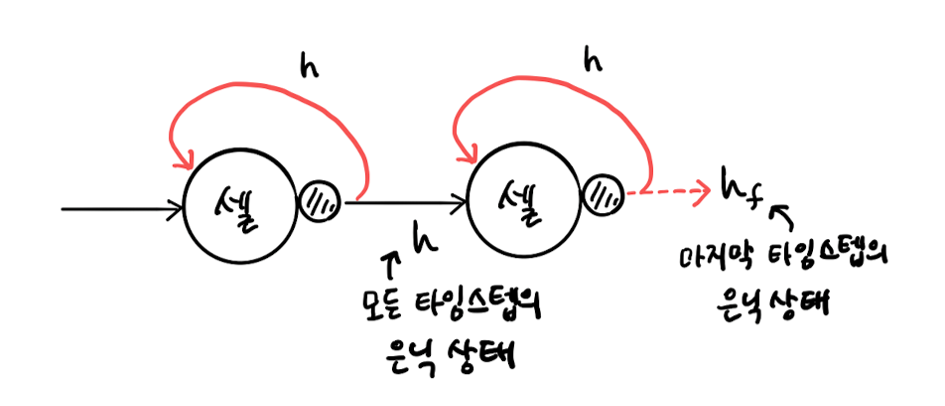

In [10]:
# 케라스의 순환층에서 모든 타임스텝의 은닉 상태를 출력하려면
# 마지막을 제외한 다른 모든 순환층에서 return_sequences=True로 지정함

model3 = keras.Sequential()

model3.add(keras.layers.Embedding(500, 16, input_shape=(100,)))
model3.add(keras.layers.LSTM(8, dropout=0.3, return_sequences=True))    # 1번 LSTM
model3.add(keras.layers.LSTM(8, dropout=0.3))   # 2번 LSTM
model3.add(keras.layers.Dense(1, activation='sigmoid'))     # 긍정 부정 리뷰에 대한 2진분류

model3.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)              │ (None, 100, 16)             │           8,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 100, 8)              │             800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 8)                   │             544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │               9 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9,353 (36.54 KB)

 Trainable params: 9,353 (36.54 KB)

 Non-trainable params: 0 (0.00 B)

첫번째 LSTM 층이 모든 타임스텝(100개)의 은닉상태를 출력하기 때문에 출력 크기가 (None, 100, 8)로 표시됨

그에 반해 두번째 LSTM 층의 출력 크기는 마지막 타임스텝의 은닉상태만 출력하기 때문에 (None, 8)이다.

In [11]:
# 훈련 시작
rmsprop = keras.optimizers.RMSprop(learning_rate=1e-4)
model3.compile(optimizer=rmsprop, loss='binary_crossentropy', metrics=['accuracy'])

checkpoint_cb = keras.callbacks.ModelCheckpoint('best-2rnn-model.keras', save_best_only=True)

early_stopping_cb = keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)

history = model3.fit(train_seq, train_target, epochs=100, batch_size=64,
                     validation_data=(val_seq, val_target),
                     callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 36s 97ms/step - accuracy: 0.5235 - loss: 0.6927 - val_accuracy: 0.5964 - val_loss: 0.6907
Epoch 2/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 43s 104ms/step - accuracy: 0.5854 - loss: 0.6888 - val_accuracy: 0.6470 - val_loss: 0.6764
Epoch 3/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 36s 89ms/step - accuracy: 0.6495 - loss: 0.6604 - val_accuracy: 0.7104 - val_loss: 0.5774
Epoch 4/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 28s 88ms/step - accuracy: 0.7134 - loss: 0.5717 - val_accuracy: 0.7346 - val_loss: 0.5318
Epoch 5/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 41s 90ms/step - accuracy: 0.7405 - loss: 0.5346 - val_accuracy: 0.7580 - val_loss: 0.5051
Epoch 6/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 43s 97ms/step - accuracy: 0.7571 - loss: 0.5090 - val_accuracy: 0.7616 - val_loss: 0.4972
Epoch 7/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 38s 89ms/step - accuracy: 0.7712 - loss: 0.4930 - val_accuracy: 0.7654 - val_loss: 0.4921
Epoch 8/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 41s 90ms/step - accuracy: 0.7732 - loss: 

드롭아웃 전에는 52회 에포크에 81.67% 정확도로 나옴 16분 걸림

드롭이웃 이후에는 43회 에포크에 81.67% 정확도 이고 13분 걸림

2개의 층으로 LSTM 적용 후 17회 에포크에 79.82% 정확도이고 11분 걸림

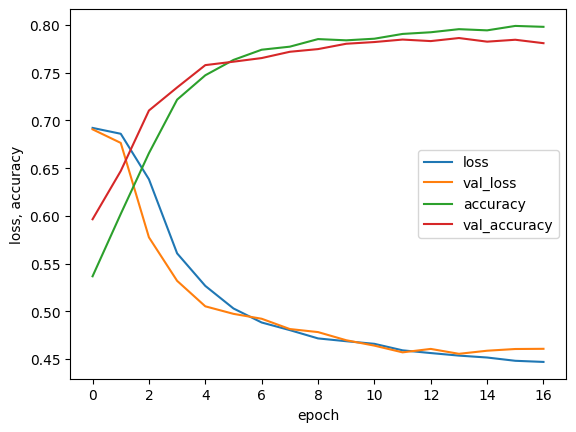

In [12]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('epoch')
plt.ylabel('loss, accuracy')
plt.legend(['loss', 'val_loss','accuracy', 'val_accuracy'])
plt.show() # 과대적합을 제어하면서 손실을 최대한 낮춘 느낌이다.

# 드롭아웃 전 : Epoch 52/100 accuracy: 0.8167 - loss: 0.4013 - val_accuracy: 0.7944 - val_loss: 0.4368
# 0.4368 - 0.4013 = 0.0355

# 드롭아웃 후 : Epoch 43/100 accuracy: 0.8167 - loss: 0.4109 - val_accuracy: 0.7944 - val_loss: 0.4381
# 0.4381 - 0.4109 = 0.0272

# 2개 층 드롭아웃 후 : Epoch 17/100 accuracy: 0.7982 - loss: 0.4452 - val_accuracy: 0.7810 - val_loss: 0.4606
# 0.4606 - 0.4452 = 0.0154

---

GRU(Gated Recurrent Units) 구조

뉴욕 대학교 조경현 교수가 발명한 셀로 유명함(LSTM을 간소화 버전으로 만듦)

셀 상태를 계산하지 않고 은닉 상태 하나만 포함하고 있다.

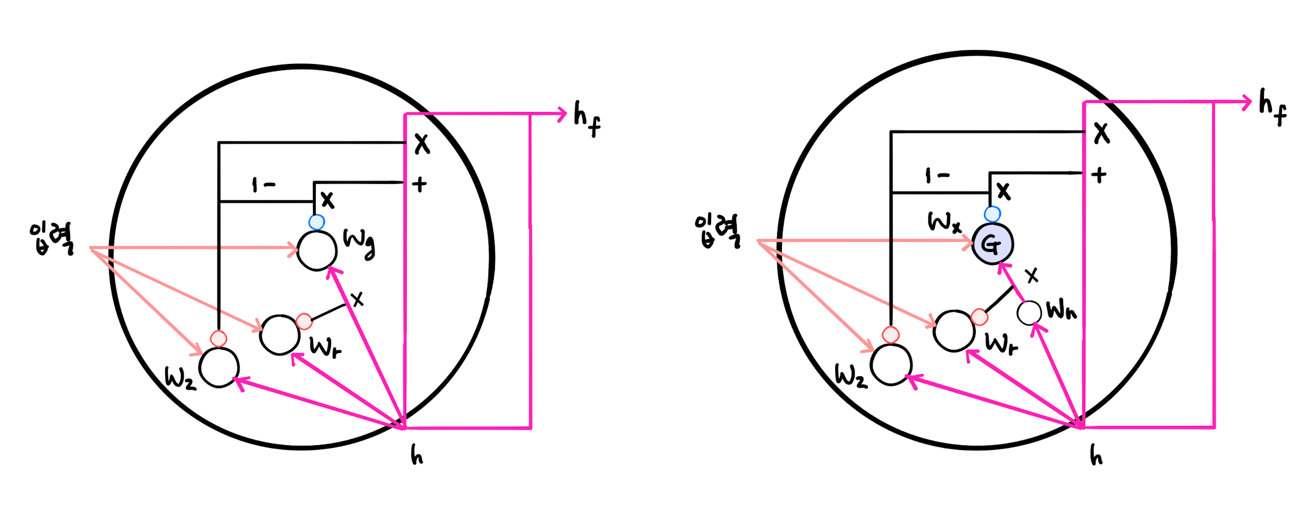

GRU 셀에는 은닉 상태와 입력에 가중치를 곱하고 절편을 더하는 작은 셀이 3개 들어있다.

2개는 시그모이드 활성화 함수를 사용하고 하나는 tanh 활성화 함수를 사용한다.

여기에도 은닉 상태와 곱해지는 가중치를 합쳐서 나타냈음

<br>

맨 왼쪽 W_z를 사용하는 셀의 출력이 은닉 상태에서 바로 곱해져 삭제 게이트 역할을 수행한다.

이와 똑같은 출력은 1에서 뺀 다음에 가장 오른쪽 W_g를 사용하는 셀의 출력에 곱한다.

이는 입력되는 정보를 제어하는 역할을 수행한다.

가운데 W_r을 사용하는 셀에서는 출력된 W_g 셀이 사용할 은닉 상태의 정보를 제어한다.

<br>

GRU 셀은 LSTM보다 가중치가 적기 때문에 계산량이 적지만 LSTM 못지 않은 좋은 성능을 낸다.

In [13]:
# GRU 신경망 훈련하기
model4 = keras.Sequential()

model4.add(keras.layers.Embedding(500, 16, input_shape=(100,)))
model4.add(keras.layers.GRU(8, dropout=0.3, return_sequences=True))     # GRU로 변경함
model4.add(keras.layers.GRU(8, dropout=0.3))
model4.add(keras.layers.Dense(1, activation='sigmoid'))

model4.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)              │ (None, 100, 16)             │           8,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru (GRU)                            │ (None, 100, 8)              │             624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_1 (GRU)                          │ (None, 8)                   │             432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │               9 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9,065 (35.41 KB)

 Trainable params: 9,065 (35.41 KB)

 Non-trainable params: 0 (0.00 B)

파라미터를 계산해보겠다. GRU 셀에는 3개의 작은 셀이 있다.

작은 셀에는 입력과 은닉 상태에 곱하는 가중치와 절편이 있다.

입력에 곱하는 가중치는 16 \* 8 = 128개이고, 은닉 상태에 곱하는 가중치는 8 \* 8 = 64이다.

절편은 뉴런마다 하나씩이므로 8개임

모두 더하면 128 + 64 + 8 = 200. 이런 작은 셀이 3개이므로 600개임

<br>

624개가 된 이유는 3개의 절편마다 8개의 뉴런까지 존재하기 때문에 3 * 8 = 24까지 더해짐

600 + (3 * 8) = 624

텐서플로가 이런 계산 방식을 사용하는 이유는 GPU를 잘 활용하기 위해서임 (LSTM 개선점)

In [14]:
# 훈련 시작
rmsprop = keras.optimizers.RMSprop(learning_rate=1e-4)
model4.compile(optimizer=rmsprop, loss='binary_crossentropy', metrics=['accuracy'])

checkpoint_cb = keras.callbacks.ModelCheckpoint('best-gru-model.keras', save_best_only=True)

early_stopping_cb = keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)

history = model4.fit(train_seq, train_target, epochs=100, batch_size=64,
                     validation_data=(val_seq, val_target),
                     callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 44s 120ms/step - accuracy: 0.4956 - loss: 0.6932 - val_accuracy: 0.5064 - val_loss: 0.6929
Epoch 2/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 44s 131ms/step - accuracy: 0.5209 - loss: 0.6928 - val_accuracy: 0.5320 - val_loss: 0.6925
Epoch 3/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 37s 117ms/step - accuracy: 0.5419 - loss: 0.6923 - val_accuracy: 0.5552 - val_loss: 0.6918
Epoch 4/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 41s 118ms/step - accuracy: 0.5533 - loss: 0.6915 - val_accuracy: 0.5814 - val_loss: 0.6905
Epoch 5/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 42s 121ms/step - accuracy: 0.5743 - loss: 0.6900 - val_accuracy: 0.6020 - val_loss: 0.6881
Epoch 6/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 40s 119ms/step - accuracy: 0.5959 - loss: 0.6870 - val_accuracy: 0.6132 - val_loss: 0.6837
Epoch 7/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 38s 122ms/step - accuracy: 0.6063 - loss: 0.6823 - val_accuracy: 0.6218 - val_loss: 0.6757
Epoch 8/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 37s 118ms/step - accuracy: 0.6213 -

드롭아웃 전에는 52회 에포크에 81.67% 정확도로 나옴 16분 걸림

드롭이웃 이후에는 43회 에포크에 81.67% 정확도 이고 13분 걸림

2개의 층으로 LSTM 적용 후 17회 에포크에 79.82% 정확도이고 11분 걸림

2개의 층으로 GRU 적용 후 28회 에포크에 80.10% 정확도이고 18분 걸림

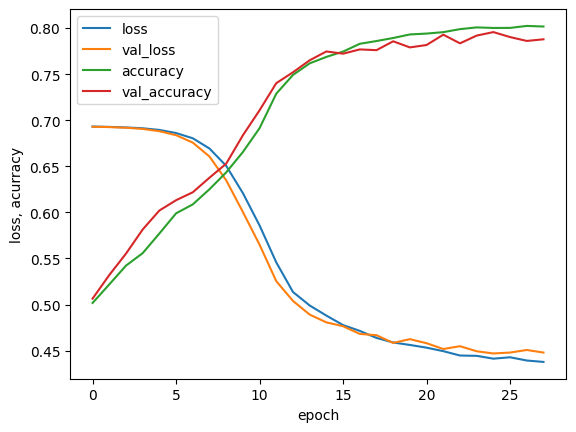

In [15]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('epoch')
plt.ylabel('loss, acurracy')
plt.legend(['loss', 'val_loss','accuracy', 'val_accuracy'])
plt.show()

# LSTM 드롭아웃 전 : Epoch 52/100 accuracy: 0.8167 - loss: 0.4013 - val_accuracy: 0.7944 - val_loss: 0.4368
# 0.4368 - 0.4013 = 0.0355

# LSTM 드롭아웃 후 : Epoch 43/100 accuracy: 0.8167 - loss: 0.4109 - val_accuracy: 0.7944 - val_loss: 0.4381
# 0.4381 - 0.4109 = 0.0272

# 2개 층 LSTM 드롭아웃 후 : Epoch 17/100 accuracy: 0.7982 - loss: 0.4452 - val_accuracy: 0.7810 - val_loss: 0.4606
# 0.4606 - 0.4452 = 0.0154

# 2개 층 GRU 드롭아웃 후 : Epoch 28/100 accuracy: 0.8010 - loss: 0.4365 - val_accuracy: 0.7878 - val_loss: 0.4479
# 0.4479 - 0.4365 = 0.0114 손실율이 점점 감소한다.

---

훈련 데이터와 검증 데이터의 훈련이 종료되면 test 데이터를 이용해서 마지막 점수를 봐야 한다.

기존에 저장한 데이터를 불러와 테스트 점수를 보자.

In [16]:
# 2층으로 만든 LSTM 모델
test_seq = pad_sequences(test_input, maxlen=100)    # 테스트 데이터 전처리
rnn_model = keras.models.load_model('best-2rnn-model.keras')    # 2층으로 만든 LSTM 모델 불러옴
rnn_model.evaluate(test_seq, test_target)   # LSTM 2층으로 만든 테스트 점수

782/782 ━━━━━━━━━━━━━━━━━━━━ 15s 18ms/step - accuracy: 0.7877 - loss: 0.4545


[0.4543180465698242, 0.7878400087356567]

In [17]:
# 2층으로 만든 GRU 모델
test_seq = pad_sequences(test_input, maxlen=100)
gru_model = keras.models.load_model('best-gru-model.keras')     # 2층으로 만든 GRU 모델 불러옴
gru_model.evaluate(test_seq, test_target)   # GRU 2층으로 만든 테스트 점수

782/782 ━━━━━━━━━━━━━━━━━━━━ 17s 21ms/step - accuracy: 0.7958 - loss: 0.4448


[0.44477444887161255, 0.7943599820137024]